In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Welcome, 
### This is my attempt at creating a conditional Deep Convolutional GAN (Generative Adverserial Network) using Tensorflow 2.0

In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython.display import clear_output
tf.__version__

'2.4.1'

In [3]:
import time

# Get data and prepare the dataset

#### This is just testing, so will just use popular data set (MNIST)

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]



11493376/11490434 [==============================] - 0s 0us/step


In [5]:
pd.DataFrame(train_labels[:50]).describe()

,0
count,50.000000
mean,4.500000
std,2.984655
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


### Check data shape

In [6]:
np.shape(train_images[1]), np.shape(train_labels[1])

((28, 28, 1), ())

# Time to create **GENERATOR** and **DISCRIMINATOR** model

### Generator Model Architecture:
Instead of only noise input, we use label and noise input in cGAN, we then concantenate both of them and transpose it


In [7]:
def make_generator_model(latent_dim=100, n_classes=10):
	# label input
	in_label = layers.Input(shape=(1,), name='label')
	# embedding for categorical input
	li = layers.Embedding(n_classes, 10)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = layers.Dense(n_nodes)(li)
	# reshape to additional channel
	li = layers.Reshape((7, 7, 1))(li)
    
    
	# image generator input
	in_lat = layers.Input(shape=(latent_dim,),name='noise')
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = layers.Dense(n_nodes)(in_lat)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	gen = layers.Reshape((7, 7, 128))(gen)
    
    
	# merge image gen and label input
	merge = layers.Concatenate()([gen, li])
    
    
	# upsample to 14x14
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = tf.keras.Model([in_lat, in_label], out_layer)
    
	return model
generator = make_generator_model(100,10)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
label (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6272)         633472      noise[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        100         label[0][0]                      
______________________________________________________________________________________________

In [8]:
#generator({'label':np.array([6,5,4]), 'noise':tf.random.normal([3,100])}, training=False)


## 2. The Discriminator
#### cGAN uses the image and label as the input for the Discriminator as supposed to image only.

In [9]:
def make_discriminator_model(in_shape=(28,28,1), n_classes=10):
    in_label = layers.Input(shape=(1,), name='label') # label input
    li = layers.Embedding(n_classes, 10)(in_label) # embedding for categorical input 
    n_nodes = in_shape[0] * in_shape[1] # scale up to image dimensions with linear activation

    li = layers.Dense(n_nodes)(li) 
    li = layers.Reshape((in_shape[0], in_shape[1], 1))(li) # reshape to additional channel

    in_image = layers.Input(shape=in_shape, name='image') # image input

    merge = layers.Concatenate()([in_image, li]) # concat label as a channel

    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = layers.LeakyReLU(alpha=0.2)(fe)

    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = layers.LeakyReLU(alpha=0.2)(fe)

    fe = layers.Flatten()(fe)

    fe = layers.Dropout(0.4)(fe)

    out_layer = layers.Dense(1, activation='sigmoid')(fe)

    # define model
    model = tf.keras.Model([in_image, in_label], out_layer)

    # compile model
    #opt = rf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        100         label[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       8624        embedding_1[0][0]                
__________________________________________________________________________________________________
image (InputLayer)              [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

In [40]:
lbl = np.array([6])
noise = tf.random.normal([1,100])
test = generator({'label':lbl, 'noise':noise}, training=False)
yo = discriminator({'label':lbl, 'image':test}, training=False)
yo

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.35921592]], dtype=float32)>

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# **TRAINING**

### Very helpful diagram from matlab on how to train cGAN
![](https://www.mathworks.com/help/examples/nnet/win64/TrainConditionalGenerativeAdversarialNetworkCGANExample_02.png)

In [15]:
@tf.function # compile function
def train_step(image_batch, label_batch):
    noise = tf.random.normal([BATCH_SIZE, 100])
    #fake_labels = tf.random.uniform(shape=(BATCH_SIZE,1), minval=0, maxval=9, dtype=tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator({'label':label_batch, 'noise':noise}, training=True)
        
        real_output = discriminator({'label':label_batch, 'image':image_batch}, training=True)
        
        fake_output = discriminator({'label':label_batch, 'image':generated_images}, training=True)
        
        # CALCULATE LOSS OF FAKE AND REAL IMAGES
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # get gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


as you can see here we need to shuffle the image and label, me being stupid shuffle both of them separately and when i train the model, the model produces undesireable results. 
the solution is to shuffle the indices and then apply those shuffled indices

In [33]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

idx = np.random.permutation(len(train_images))
x,y = train_images[idx], train_labels[idx]

image_dataset = tf.data.Dataset.from_tensor_slices(x[:-96]).batch(BATCH_SIZE)
label_dataset = tf.data.Dataset.from_tensor_slices(y[:-96]).batch(BATCH_SIZE)

# indices = tf.range(start=0, limit=tf.shape(image_dataset)[0], dtype=tf.int32)
# idx = tf.random.shuffle(indices)
# image_dataset = tf.gather(train_images, idx)
# label_dataset = tf.gather(train_labels, idx)


#dataset = zip(image_dataset, label_dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [17]:
image_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [18]:
np.size(label_dataset)

1

# ######################################

In [19]:
seed = tf.random.normal([10, 100])
seed_label = np.array([0,1,2,3,4,5,6,7,8,9])

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = generator({'label':seed_label, 'noise':seed}, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# 


In [36]:
# for image_batch, label_batch in zip(image_dataset, label_dataset):
#     #train_step(image_batch, label_batch)
#     #display(plt.imshow(image_batch[9]), label_batch[9])
#     display(len(image_batch))
    


In [24]:
epochs = 200

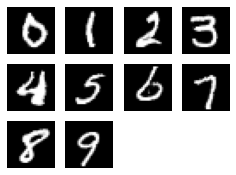

In [35]:
for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in zip(image_dataset, label_dataset):
        train_step(image_batch, label_batch)

# Produce images for the GIF as you go
    clear_output(wait=True)
    generate_and_save_images(generator,
                         epoch + 1,
                         seed)

# Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the final epoch
clear_output(wait=True)
generate_and_save_images(generator,
                       epochs,
                       seed)

In [37]:
# generator.save('./generator')
# discriminator.save('./discriminator')

In [38]:
# import shutil
# shutil.make_archive('generator.zip', 'zip', './generator')
# shutil.make_archive('discriminator.zip', 'zip', './discriminator')


'/kaggle/working/discriminator.zip.zip'

# TESTING AFTER TRAINING

[7]


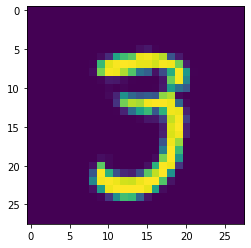

[7]


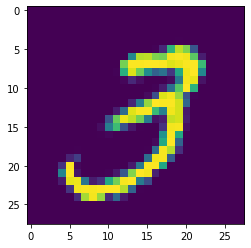

[7]


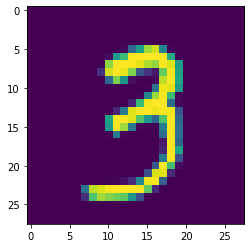

[7]


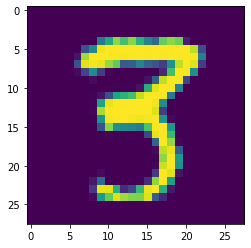

[7]


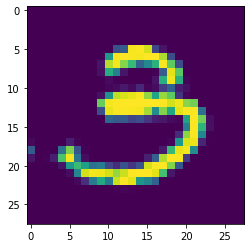

[7]


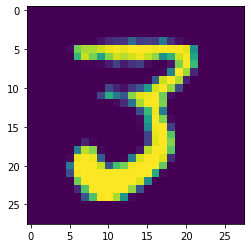

[7]


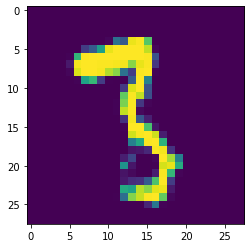

[7]


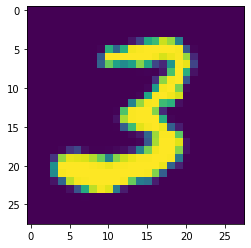

[7]


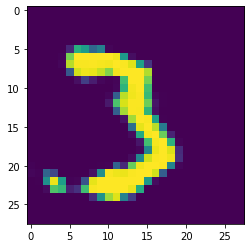

[7]


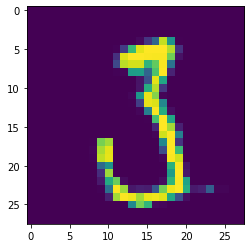

[7]


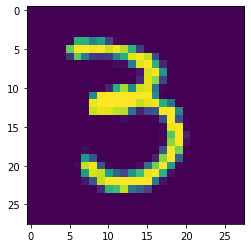

[7]


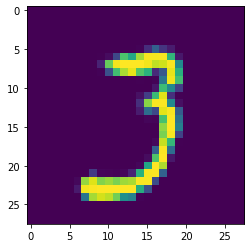

[7]


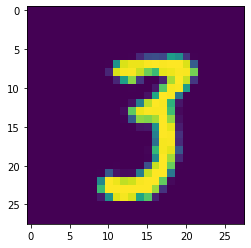

[7]


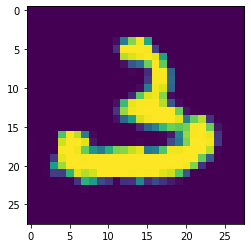

[7]


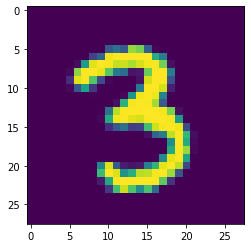

[7]


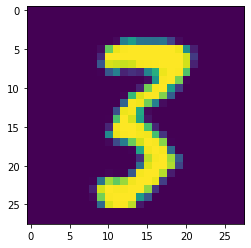

[7]


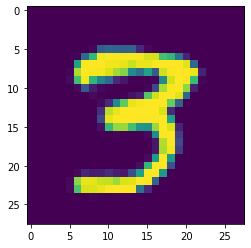

[7]


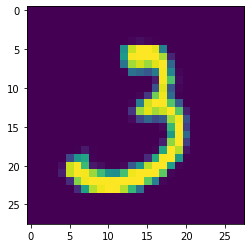

[7]


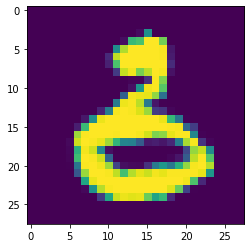

[7]


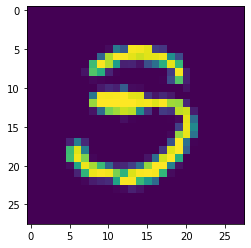

In [108]:
NUM = 3

for n in range(20):
    test = generator({'label':np.array([NUM]), 'noise':tf.random.normal([1,100])}, training=False)
    print(lbl)
    plt.imshow(test[0])
    plt.show()

[7]


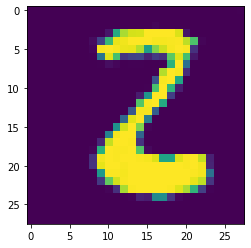

[7]


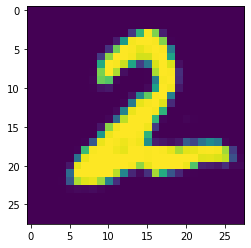

[7]


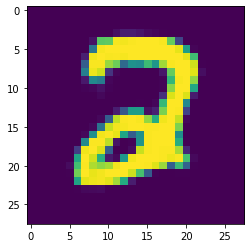

[7]


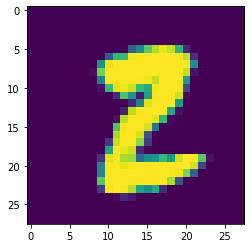

[7]


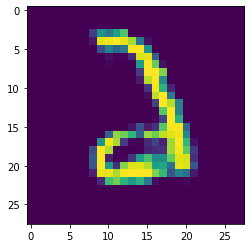

[7]


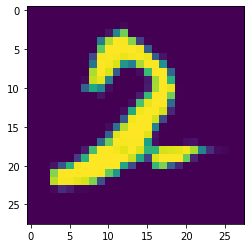

[7]


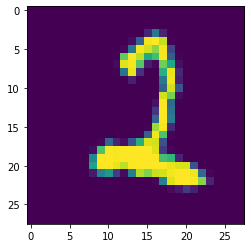

[7]


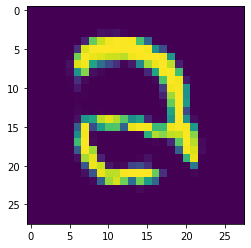

[7]


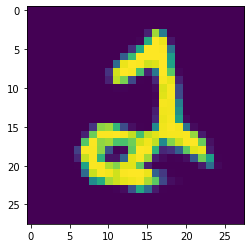

[7]


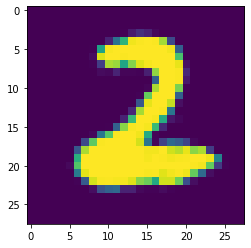

[7]


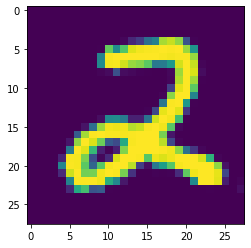

[7]


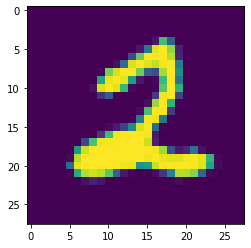

[7]


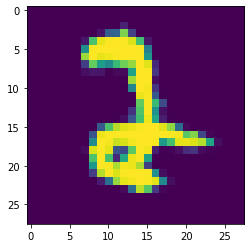

[7]


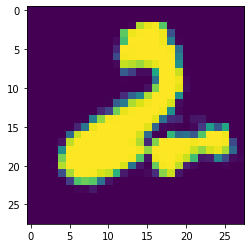

[7]


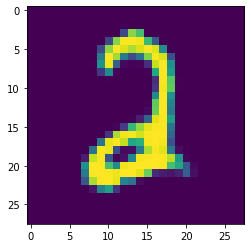

[7]


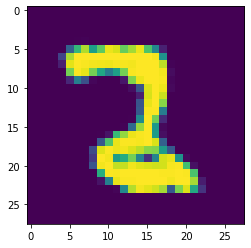

[7]


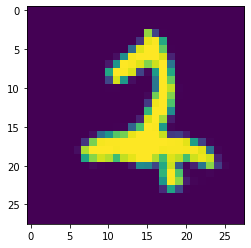

[7]


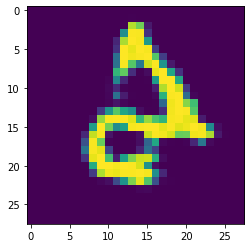

[7]


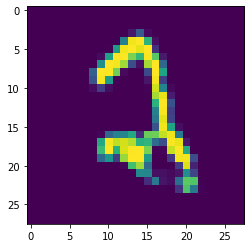

[7]


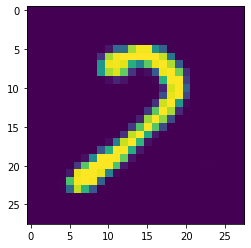

In [109]:
NUM = 2

for n in range(20):
    test = generator({'label':np.array([NUM]), 'noise':tf.random.normal([1,100])}, training=False)
    print(lbl)
    plt.imshow(test[0])
    plt.show()